In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


c:\Users\devpa\anaconda3\envs\xgboost-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Filter dataset to get collumns of interest

Due to the nature of the dataset, the 10 year yeild values only start 10 years after the dataset, whereas years 1-7 start from the beginning. So using these values we hope to predict the missing values 


In [3]:
yield_data = pd.read_csv("data/yield.csv")


# Convert to datetime and set as index
yield_data['Date'] = pd.to_datetime(yield_data['Date'])
yield_data.set_index('Date', inplace=True)

# Replace invalid values with NaN
yield_data.replace(-999.99, pd.NA, inplace=True)

# Drop columns with more than 20% missing values
threshold = 0.2 * len(yield_data)
columns_to_drop = yield_data.columns[yield_data.isnull().sum() > threshold]
yield_data_drop = yield_data.drop(columns=columns_to_drop)

# Rename columns
column_rename_mapping = {
    'BETA0': 'LongTermRate',    # Reflects investor confidence about long-term economic growth and inflation
    'BETA1': 'Slope',           # A negative slope (yield curve inversion) signals a possible recession
}


# https://www.federalreserve.gov/pubs/feds/2006/200628/200628pap.pdf   <=== labels for the columns plus info on data
for i in range(1, 30):
    column_rename_mapping[f'SVENY{i:02d}'] = f'ZeroCouponYield{i}Y'
    column_rename_mapping[f'SVENF{i:02d}'] = f'InstantaneousForwardRate{i}Y'
    yield_data = yield_data.drop(columns=f'SVENPY{i:02d}')
yield_data.rename(columns=column_rename_mapping, inplace=True)


# Resample to monthly frequency (convert from 'B' to 'M')
yield_data = yield_data.resample('M').mean()

# Interpolate missing values 
yield_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)


columns_of_interest = ['Slope', 'LongTermRate'] + \
                      [f'ZeroCouponYield{i}Y' for i in range(1, 11)] + \
                      [f'InstantaneousForwardRate{i}Y' for i in range(1, 11)]


new_yield_data = yield_data[columns_of_interest]


new_yield_data.to_csv("filtered_yield_data.csv")



In [ ]:
new_yield_data

### XGBoost

In [43]:
yield_data = pd.read_csv("filtered_yield_data.csv")

# Flip the dataset so missing data goes to the end
flipped_data = yield_data.iloc[::-1]

# Columns for predictors and target
predictors = ['ZeroCouponYield1Y', 'ZeroCouponYield2Y', 'ZeroCouponYield3Y',
              'ZeroCouponYield4Y', 'ZeroCouponYield5Y', 'ZeroCouponYield6Y',
              'ZeroCouponYield7Y']
target = 'ZeroCouponYield10Y'

# Drop rows where predictors or target are missing
cleaned_data = flipped_data.dropna(subset=predictors + [target])

# Split data into features (X) and target (y)
X = cleaned_data[predictors]
y = cleaned_data[target]

# Train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_test)
print(f"Mean Absolute Error on Test Set: {mae:.2f}")


Mean Absolute Error on Test Set: 0.09


In [44]:
# Predict missing values for ZeroCouponYield10Y/ inst rate
missing_data = flipped_data[flipped_data[target].isna()]
if not missing_data.empty:
    missing_predictions = model.predict(missing_data[predictors])
    flipped_data.loc[missing_data.index, target] = missing_predictions

# Reverse the dataset back to its original order
final_data = flipped_data.iloc[::-1].reset_index(drop=True)

columns_to_drop = [col for col in final_data.columns if '8Y' in col or '9Y' in col]
final_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')


# Save the updated dataset
updated_file_path = 'past_yield_data.csv'  # Adjust path if needed
final_data.to_csv(updated_file_path, index=False)

print(f"Updated dataset saved to {updated_file_path}")


Updated dataset saved to past_yield_data.csv


In [45]:
final_data

,Date,Slope,LongTermRate,ZeroCouponYield1Y,ZeroCouponYield2Y,ZeroCouponYield3Y,ZeroCouponYield4Y,ZeroCouponYield5Y,ZeroCouponYield6Y,ZeroCouponYield7Y,ZeroCouponYield10Y,InstantaneousForwardRate1Y,InstantaneousForwardRate2Y,InstantaneousForwardRate3Y,InstantaneousForwardRate4Y,InstantaneousForwardRate5Y,InstantaneousForwardRate6Y,InstantaneousForwardRate7Y,InstantaneousForwardRate10Y
0,1961-06-30,-1.268221,4.002757,2.974685,3.383562,3.580031,3.684631,3.748146,3.790554,3.820877,4.235296,3.533592,3.934585,3.993169,4.001369,4.002562,4.002731,4.002762,4.295547
1,1961-07-31,-1.967420,4.100839,2.841955,3.289770,3.531040,3.668470,3.754025,3.811640,3.852910,4.235296,3.436640,3.934995,4.062475,4.092050,4.098790,4.100355,4.100720,4.396466
2,1961-08-31,-1.712356,4.248369,3.001652,3.420465,3.661852,3.802339,3.890426,3.949861,3.992443,4.410614,3.522839,4.054435,4.201822,4.237530,4.245861,4.247778,4.248226,4.601078
3,1961-09-30,-1.691689,4.130283,3.043195,3.445030,3.654595,3.770960,3.842475,3.890400,3.924650,4.286585,3.581385,4.014040,4.108765,4.126550,4.129645,4.130185,4.130270,4.391633
4,1961-10-31,-1.607382,3.815504,2.962929,3.350962,3.559624,3.674895,3.739548,3.776095,3.796800,4.233970,3.489457,3.907943,4.016624,4.014843,3.979167,3.938957,3.904257,3.946262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2024-07-31,3.155800,2.384022,4.843450,4.459173,4.254350,4.154305,4.116082,4.114377,4.134009,4.243741,4.332027,3.902305,3.824605,3.899205,4.032232,4.179814,4.321741,4.651005
758,2024-08-31,1.158210,4.366392,4.378077,3.932977,3.759623,3.699645,3.691705,3.710009,3.742368,3.870782,3.692477,3.394745,3.455164,3.588405,3.731395,3.870400,4.000941,4.320395
759,2024-09-30,0.838962,4.658334,3.991825,3.590410,3.487035,3.472960,3.492130,3.527310,3.571365,3.722075,3.269610,3.204920,3.357815,3.501085,3.636180,3.770015,3.900285,4.227915
760,2024-10-31,1.049625,3.829619,4.171550,3.940541,3.872355,3.867236,3.890018,3.926364,3.969373,4.107732,3.787459,3.694064,3.789077,3.916245,4.045500,4.169250,4.284005,4.559245


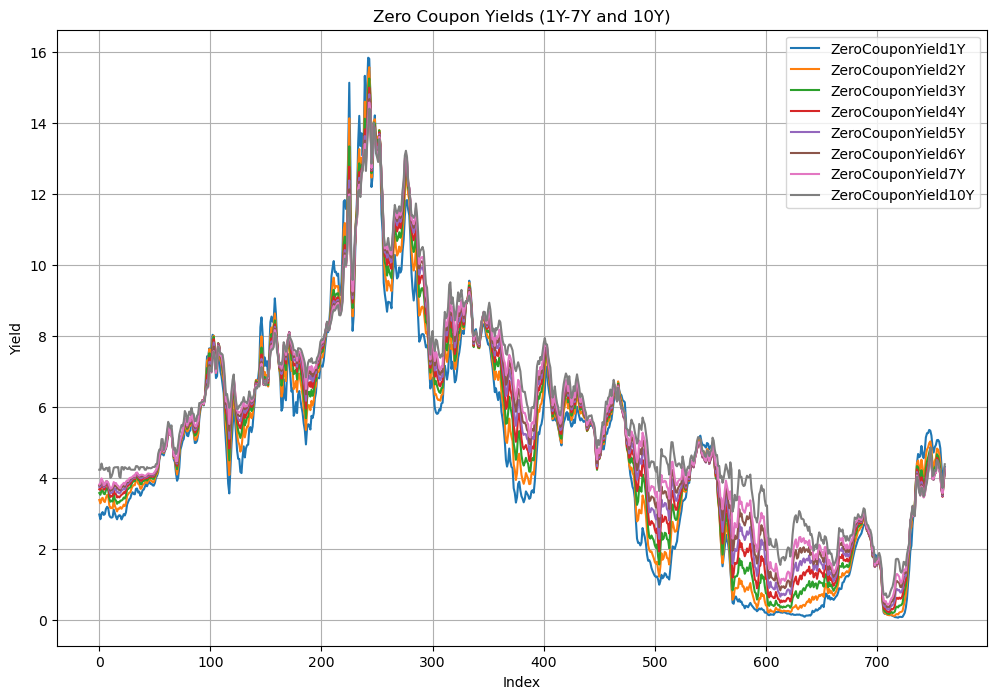

In [46]:


# Reload the processed dataset
exported_data = pd.read_csv('clean_data/past_yield_data.csv')

# Columns to plot
columns_to_plot = [
    'ZeroCouponYield1Y',
    'ZeroCouponYield2Y',
    'ZeroCouponYield3Y',
    'ZeroCouponYield4Y',
    'ZeroCouponYield5Y',
    'ZeroCouponYield6Y',
    'ZeroCouponYield7Y',
    'ZeroCouponYield10Y'
]


# Plot the columns
plt.figure(figsize=(12, 8))
for col in columns_to_plot:
    plt.plot(exported_data[col], label=col)

# Add labels, legend, and title
plt.xlabel('Index')
plt.ylabel('Yield')
plt.title('Zero Coupon Yields (1Y-7Y and 10Y)')
plt.legend()
plt.grid()
plt.show()

The grey line from 0-50 is the predicted output, however it doesn't seem to track the consosadation period before the value rises

### Variable Autoencoder

In [36]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

data = pd.read_csv("updated_yield_data.csv")

# Flip the dataset so missing data goes to the end
data = data.iloc[::-1]

# Use years 1–7 as inputs and 10Y as targets for missing value prediction
input_columns = [f"InstantaneousForwardRate{i}Y" for i in range(1, 8)]
target_column = "InstantaneousForwardRate10Y"

# Filter out rows where all inputs (years 1–7) are non-missing
valid_data = data.dropna(subset=input_columns)
input_data = valid_data[input_columns].values
target_data = valid_data[target_column].values

# Scale the inputs and targets to [0, 1] using MinMaxScaler
scaler_inputs = MinMaxScaler()
scaler_targets = MinMaxScaler()

scaled_inputs = scaler_inputs.fit_transform(input_data)
scaled_targets = scaler_targets.fit_transform(target_data.reshape(-1, 1))

missing_data_rows = data[data[target_column].isna()]
prediction_inputs = scaler_inputs.transform(missing_data_rows[input_columns].values)

# Confirm scaling and data preparation
scaled_inputs.shape, scaled_targets.shape, prediction_inputs



((762, 7),
 (762, 1),
 array([[0.42208968, 0.46218045, 0.47748506, 0.47902748, 0.47482741,
         0.46819027, 0.46050552],
        [0.38772632, 0.43805492, 0.46028856, 0.46514844, 0.46240895,
         0.45640177, 0.4489879 ],
        [0.36404184, 0.42335034, 0.44891898, 0.45488934, 0.4525254 ,
         0.4466506 , 0.43928853],
        [0.31388533, 0.38040635, 0.41615852, 0.43025365, 0.43374976,
         0.43201278, 0.42756714],
        [0.26005011, 0.3280167 , 0.37715348, 0.40697458, 0.42447557,
         0.4339798 , 0.43816892],
        [0.2802931 , 0.3753369 , 0.43011094, 0.45208578, 0.45792099,
         0.45632328, 0.45128501],
        [0.33165169, 0.40317612, 0.43684889, 0.44748803, 0.4477078 ,
         0.44322817, 0.43661166],
        [0.34697355, 0.39882988, 0.42741281, 0.43749932, 0.43836618,
         0.43471154, 0.42880706],
        [0.38524202, 0.4337474 , 0.45854576, 0.46669366, 0.46677921,
         0.4628926 , 0.45697238],
        [0.43508343, 0.47528708, 0.49295593, 0.4957

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras import backend as K
import tensorflow as tf

# Define the VAE structure
input_dim = scaled_inputs.shape[1]
latent_dim = 2

# Encoder
encoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(latent_dim, name="latent")
])

# Decoder
decoder = Sequential([
    Input(shape=(latent_dim,)),
    Dense(16, activation="relu"),
    Dense(32, activation="relu"),
    Dense(input_dim, activation="sigmoid", name="output")
])

# VAE: connect encoder and decoder
inputs = Input(shape=(input_dim,))
z = encoder(inputs)
reconstructed = decoder(z)

vae = tf.keras.Model(inputs, reconstructed)

# Loss: reconstruction loss + KL divergence
reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, reconstructed)
kl_loss = -0.5 * K.sum(1 + encoder.layers[-1].weights[1] - tf.square(encoder.layers[-1].weights[0]) -
                        tf.exp(encoder.layers[-1].weights[1]), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

# Train the VAE
vae.fit(scaled_inputs, scaled_inputs, epochs=50, batch_size=32, verbose=1)

# Predict missing 10Y values using the VAE
latent_predictions = encoder.predict(prediction_inputs)
reconstructed_predictions = decoder.predict(latent_predictions)

# Rescale predictions back to the original scale
predicted_10y = scaler_targets.inverse_transform(reconstructed_predictions[:, -1].reshape(-1, 1))

# Display the first 5 predictions
predicted_10y[:5]


Epoch 1/50
24/24 [==============================] - 1s 9ms/step - loss: 0.2160
Epoch 2/50
24/24 [==============================] - 0s 7ms/step - loss: 0.2082
Epoch 3/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1926
Epoch 4/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1771
Epoch 5/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1709
Epoch 6/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1675
Epoch 7/50
24/24 [==============================] - 0s 4ms/step - loss: 0.1648
Epoch 8/50
24/24 [==============================] - 0s 4ms/step - loss: 0.1628
Epoch 9/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1617
Epoch 10/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1611
Epoch 11/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1608
Epoch 12/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1607
Epoch 13/50
24/24 [==============================

array([[7.549872 ],
       [7.3298435],
       [7.156498 ],
       [6.898789 ],
       [6.706124 ]], dtype=float32)

In [39]:
# Flatten the predictions to ensure compatibility
data.loc[data[target_column].isna(), target_column] = predicted_10y.flatten()

# Save the updated dataset in its original format
data.iloc[::-1].to_csv('updated_yield_data.csv', index="Date")
print("Updated dataset saved as 'updated_yield_data.csv'.")


Updated dataset saved as 'updated_yield_data.csv'.


In [ ]:
data

In [40]:
data = pd.read_csv('updated_yield_data.csv')
data = data.set_index("Date")


In [41]:
data.to_csv("updated_yield_data.csv")

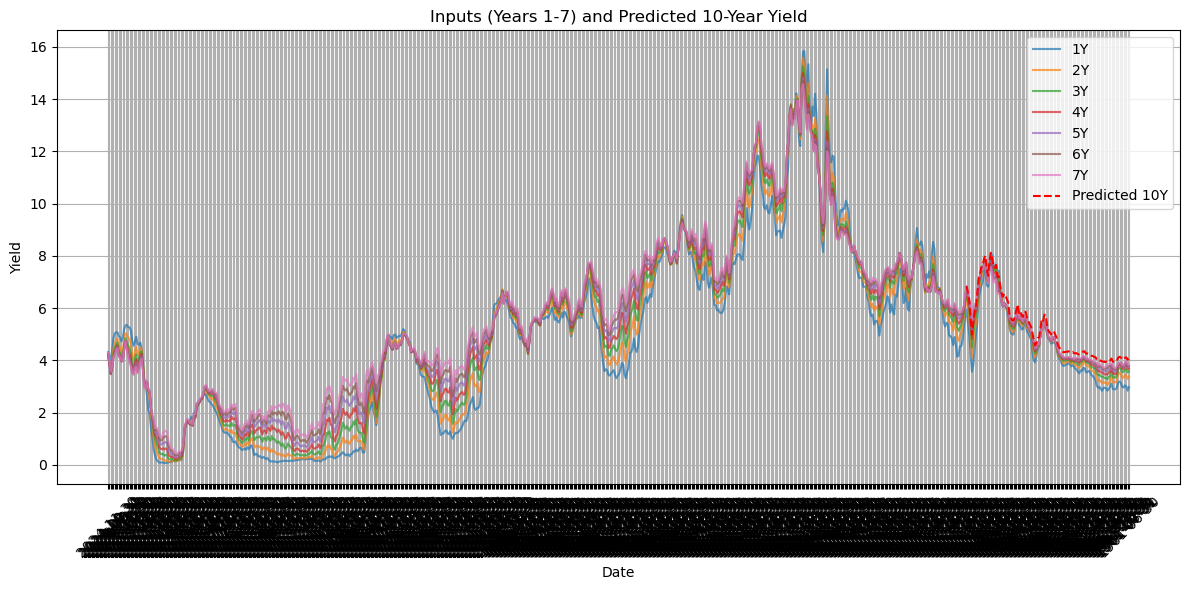

In [10]:
import matplotlib.pyplot as plt

# Assuming predictions and inputs are available, flip predictions back to original order
flipped_predictions = np.full((data.shape[0], 1), np.nan)
flipped_predictions[data[target_column].isna()] = predicted_10y

# Create a dataset combining original and predicted values for plotting
flipped_data_with_predictions = data.copy()
flipped_data_with_predictions["Predicted10Y"] = flipped_predictions

# Plot the inputs (Years 1–7) and predictions
plt.figure(figsize=(12, 6))
for i, column in enumerate(input_columns, start=1):
    plt.plot(
        flipped_data_with_predictions.index,
        flipped_data_with_predictions[column],
        label=f"{i}Y",
        alpha=0.7
    )

# Add predictions to the plot
plt.plot(
    flipped_data_with_predictions.index,
    flipped_data_with_predictions["Predicted10Y"],
    label="Predicted 10Y",
    linestyle="--",
    color="red"
)

# Customize plot
plt.xlabel("Date")
plt.ylabel("Yield")
plt.title("Inputs (Years 1-7) and Predicted 10-Year Yield")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
flipped_data_with_predictions